# Memory managment in OpenCL

In previous lessons we have looked at straightforward ways in which memory was allocated on the host and then copied to the device for use as global memory by the kernel. In the introduction we briefly covered the five different memory spaces that are accessible to an OpenCL Program.

* Host memory
* Global memory
* Local (shared) memory
* Private memory
* Constant memory

**Host memory** is usually the largest memory space on the host, and **global memory** is the largest and slowest memory space available on the compute device. **Local** and **Constant** memory is usually placed in the small, fast caches on the compute device. **Private memory** is usually located in the registers, which are normally the fastest and smallest memory spaces available on the compute device. A programmer has some degree of control over where memory is stored during the operation of an OpenCL program. The diagram below shows what memory is available for access by both host and kernel threads (work-items) at runtime. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

Kernel threads (work-items) can access *global*, *constant*, *local* and *private* memory, whereas host threads can only access *host* and *global* memory. Private memory for a kernel thread is exclusive to the kernel, meaning that no other kernel can access the same private memory. Local memory is accessible to all kernel threads in a workgroup, but not to kernel threads from another workgroup. *Global* and *Constant* memory is accessible from all kernel threads.

## Memory access from the host

From the introduction we know that Buffers are allocated on the host and they are migrated in and out of the compute device when they are needed. Here are some ways we can create Buffers and transfer memory in and out of them. 

### Buffer creation

Thus far we have been creating Buffers with the [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) function using the **CL_MEM_READ_WRITE** flag. For example, this code creates a Buffer that has read-write access from the kernel, but no additional functionality.

```C++
    cl_mem buffer_C = clCreateBuffer(context, 
                                     CL_MEM_READ_WRITE, 
                                     nbytes_C, 
                                     NULL, 
                                     &errcode);
```

#### IO permission flags

We can choose other IO flags to let the OpenCL implementation how the Buffer is to be used. This may unlock additional optimisations.

| **Allocation flag** | **Functionality** | 
| :- | :- | 
|CL_MEM_READ_WRITE| Read-write access from a kernel | 
|CL_MEM_WRITE_ONLY| Write-only access from a kernel | 
|CL_MEM_READ_ONLY | Read-only access from a kernel | 
|CL_MEM_HOST_WRITE_ONLY | Write-only access from the host | 
|CL_MEM_HOST_READ_ONLY | Read-only access from the host | 
|CL_MEM_HOST_NO_ACCESS | No access from the host | 

Common-sense rules apply in the use of these flags, for example **CL_MEM_WRITE_ONLY** is incompatible with **CL_MEM_READ_WRITE**, and behaviour is undefined if one tries to write to a buffer that has been set as **CL_MEM_READ_ONLY**.

#### Using host memory

The flag **CL_MEM_USE_HOST_PTR** allows the Buffer to use host memory as the backing store for a Buffer. One must make sure that there is enough host memory allocated to cover the memory used by the buffer and that the host memory is not de-allocated while the buffer is using it. OpenCL implementations are free to allocate caches on the compute device for temporary usage and then synchronize as required. Memory synchronization can be explicitly done using **mapping**, which will be discussed shortly.

Similarly, the flag **CL_MEM_COPY_HOST_PTR** creates an OpenCL buffer but copies memory from a host pointer during buffer creation. After the copy finishes, the host pointer is then released.  

Both **CL_MEM_USE_HOST_PTR** and **CL_MEM_COPY_HOST_PTR** require a host pointer to be passed into the call to [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html).

In the source code of [mat_mult.cpp](mat_mult.cpp) we demonstrate this by using **array_A** as the backing store for **buffer_A** by adding in  CL_MEM_HOST_PTR flag.

```C++
    // Make buffer_A using array_A as the backing store
    cl_mem buffer_A = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_USE_HOST_PTR, 
        nbytes_A, 
        (void*)array_A, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_A");
```

#### Creating buffers for fast IO

Pinned memory is host memory that cannot be paged out to swap. It enables fast and efficient Direct Memory Access (DMA) transfers from the host, however for OS health reasons the amount of pinned memory is limited to a fraction of the available memory. Normally, transfers between host and device - for example using [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) or [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) - are synchronous, meaning they actually block until the transfer completes. The flag **CL_MEM_ALLOC_HOST_PTR** allocates pinned memory on the host as the backing store for the OpenCL buffer. This also enables asynchronous transfers so that IO movement can occur at the same time as compute. In [mat_mult.cpp](mat_mult.cpp) we create **buffer_C** from pinned host memory by adding the **CL_MEM_ALLOC_HOST_PTR** flag.

```C++
    // Allocate buffer C from pinned host memory
    cl_mem buffer_C = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_ALLOC_HOST_PTR, 
        nbytes_C, 
        NULL, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_C");
```


### Explicit memory movement

The OpenCL 1.2 and earlier standards require explicit memory transfers between OpenCL buffer and host. You have the option of copying either contiguous or rectangular regions of allocated memory. By rectangular I mean that if the memory allocation is interpreted as being **folded into a multidimensional array** then a rectangular copy would copy a rectangular region of that array.

#### Contiguous copies

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/contiguous_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Contiguous memory copy.</figcaption>
</figure>

If you need to copy contiguous chunks of memory, then [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBuffer.html) **writes to** the OpenCL buffer from host memory and [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) reads **from** a buffer to host memory. The function [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBuffer.html) performs a copy of contiguous memory between two OpenCL buffers **within the same OpenCL context**. All three options have the ability to specify a starting offset (in bytes) within the OpenCL buffer, and [clEnqueueCopyBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBuffer.html) has the additional capability to specify the offset for the destination buffer.

#### Rectangular copies

Sometimes a contiguous copy is not sufficient, particularly when you treat the the allocation as a multi-dimensional array and wish to copy a rectangular region. The functions [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueWriteBufferRect.html) **writes** a 3D rectangular region to the OpenCL buffer from host memory and [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueReadBufferRect.html) **reads** a 3D rectangular region from host memory. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/rectangular_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

I found the documentation on these functions quite confusing to comprehend, particularly in translating from one indexing system (i.e row-major) to another. It is important to remember that in the documentation the word **"row"**  is the dimension along which memory is contiguous. **Row pitch** is the number of bytes along a row of **the memory allocation**, and **slice pitch** is the number of bytes in a slice of **the memory allocation**. Within the memory allocation a **region** is selected for the copy, it is of size (nbytes along the row, nrows, nslices). If you are only doing a 2D copy then use a value of 1 for **nslices**. The copy can be located at an **origin** within the memory allocations, this has units of (offset in bytes along a row, row id, slice id). Row id and slice id's are indices starting at 0. 

Rectangular copies result in more efficient copies than enqueuing numerous calls to the contiguous memory copy functions to cover the same region. In similar fashion, the function  [clEnqueueCopyBufferRect](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueCopyBufferRect.html) copies 3D rectangular regions between OpenCL buffers. In [mat_mult.cpp](mat_mult.cpp) we use a rectangular copy to copy memory from **array_B** to **buffer_B**.

```C++
    // Do a rectangular copy from host to memory in buffer_B
    
    // B is of size (N1_A, N1_C)
    // Offset is in bytes, row_id and slice_id are indices
    size_t offset=0, row_id=0, slice_id = 0;
    
    // Make up the origin for host and buffer
    const size_t buffer_origin[] = {offset, row_id, slice_id};
    const size_t host_origin[] = {offset, row_id, slice_id};
    
    // Length of a row (in bytes)
    size_t buffer_row_pitch = N1_C * sizeof(cl_float); 
    size_t host_row_pitch = buffer_row_pitch;
    
    // Number of bytes in a slice 
    size_t buffer_slice_pitch = N1_A * buffer_row_pitch;
    size_t host_slice_pitch = N1_A * host_row_pitch;        
        
    /// Size of the region to copy, of course we only copy 1 slice
    size_t nrows = N1_A, nslices = 1;
    const size_t region[] = {buffer_row_pitch, nrows, nslices};
     
    // Enqueue the rectangular copy
    h_errchk(
        clEnqueueWriteBufferRect(
            command_queue,
            buffer_B,
            CL_TRUE,
            buffer_origin,
            host_origin,
            region,
            buffer_row_pitch,
            buffer_slice_pitch,
            host_row_pitch,
            host_slice_pitch,
            array_B,
            0,
            NULL,
            NULL
        ),
        "Rectangular copy to buffer_B from the host"
    );
```


#### Buffer mapping

With the contiguous and rectangular copies there are two memory spaces in use, one for the OpenCL buffer and one for the host. It is possible to map (or make available) an OpenCL buffer as an allocation of host memory, thus avoiding the explicit memory transfer. This approach can be particularly beneficial when a CPU or integrated GPU is employed, as the memory for the buffer is already on the host and no actual transfer from the device is needed. Buffer mapping can be useful for GPU's as well. With buffer mapping the OpenCL implementation has the opportunity to optimise transfers and synchronisation between OpenCL buffer and host. The command [clEnqueueMapBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueMapBuffer.html) maps an OpenCL buffer into host memory. It uses the following mapping flags:

| **Mapping flag** | **Functionality** | 
| :- | :- | 
|CL_MAP_READ | The buffer is being mapped for reading | 
|CL_MAP_WRITE | The buffer is being mapped for writing | 
|CL_MAP_WRITE_INVALIDATE_REGION | The buffer is going to be written by the host soon and we don't need to care what is in it (potential source of optimisation).

When a buffer is mapped to the host access to the buffer from an OpenCL kernel is considered to be undefined behaviour. The [clEnqueueUnmapMemObject](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueUnmapMemObject.html) function unmaps the memory from the host and makes it available to kernels again. In [mat_mult.cpp](mat_mult.cpp) we map buffer_C back to the host and make the memory available to the host as **array_C**. Then we write **array_C** to disk before unmapping **buffer_C**.

```C++
    // Map the buffer_C back to the host so we can write it to disk
    cl_float* array_C = (cl_float*)clEnqueueMapBuffer(
        command_queue,
        buffer_C,
        CL_TRUE,
        CL_MAP_READ,
        0,
        nbytes_C,
        0,
        NULL,
        NULL,
        &errcode
    );
    h_errchk(errcode, "Mapping matrix C from device to host");
    
    // Write out the result to file
    h_write_binary(array_C, "array_C.dat", nbytes_C);

    // Unmap buffer_C so we can release it
    h_errchk(
        clEnqueueUnmapMemObject(
            command_queue,
            buffer_C,
            (void*)array_C,
            0,
            NULL,
            NULL
        ),
        "Unmapping array C"
    );
```


#### Initialisation

Sometimes you need to fill or initialise the contents of a buffer. The [clEnqueueFillBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clEnqueueFillBuffer.html) command fills buffers with a user-defined pattern such as 0, for example.

## Running the application

In [4]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 256
NROWS_C = 520
NCOLS_C = 1032

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

In [7]:
!make clean; make; ./mat_mult.exe -cpu

rm -r *.exe
g++ -g -O2 -fopenmp -I/usr/include -I../include -L/usr/lib64 mat_mult.cpp\
	-o mat_mult.exe -lOpenCL -lomp
In file included from mat_mult.cpp:16:0:
../include/cl_helper.hpp: In function ‘_cl_command_queue** h_create_command_queues(_cl_device_id**, _cl_context**, cl_uint, cl_uint, cl_bool, cl_bool)’:
../include/cl_helper.hpp:315:9: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated [-Wdeprecated-declarations]
         );
         ^
In file included from /usr/include/CL/opencl.h:24:0,
                 from ../include/cl_helper.hpp:15,
                 from mat_mult.cpp:16:
/usr/include/CL/cl.h:1906:1: note: declared here
 clCreateCommandQueue(cl_context                     context,
 ^~~~~~~~~~~~~~~~~~~~
	               name: AMD Ryzen Threadripper 2950X 16-Core Processor  
	 global memory size: 135049 MB
	    max buffer size: 33762 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
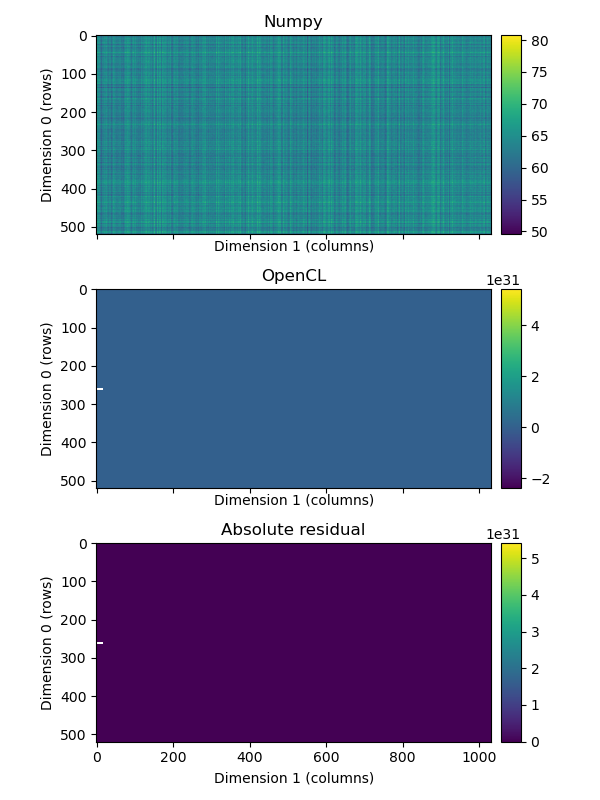

In [8]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

## Memory control and access from kernels

Kernels have access to the following memory spaces:

* Global memory
* Local (shared) memory
* Private memory
* Constant memory

[This link](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/addressSpaceQualifiers.html) provides more information on the memory spaces. Variables defined in kernel sources can be (and sometimes must be) qualified as to which memory space they belong to. There is, however a myriad of rules to navigate, as we shall see below.

### Global address space

Allocations of memory in the **global address space** are qualified by a **\_\_global** or **global** qualifier in front of the variable. Both are valid and you don't need to put the **\_\_** in front of **global**. I'm just doing it here so Jupyter syntax highlighting picks up the qualifier. Pointers to buffer allocations passed in to kernels **always** need to have the **\_\_global** qualifier. We see this in the kernel definition for **mat_mult** in [kernels_mat_mult.c](kernels_mat_mult.c).

```C
// kernels_mat_mult.c source

__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) {
```

It is interesting that inside the kernel I can use a different variable type for the pointers to interpret the memory allocation **as another type**. For example we can change the pointer type in the kernel to float4*

```C
__kernel void mat_mult (__global float4* A, 
                        __global float4* B, 
                        __global float4* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) {
```

and interpret the input buffers as arrays of the vector type **float4**. Of course we need to ensure that we don't go off the end of the array, and that the number of floats allocated is a multiple of four. 

Variables in the global address space can be declared outside kernel functions if the **\_\_opencl_c_program_scope_global_variables** macro is defined.

```C
// kernels_mat_mult.c source

// Example of a global variable
#ifdef __opencl_c_program_scope_global_variables
__global int a_g = 2; 
__global float b_g[2] = {2.0,1.0}; 
#endif

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A,... 
```

If **a_g** and **b_g** are defined, then the variables are available to every kernel that runs in the program on the compute device.

### Constant

The constant address space is usually located in a fast cache and is defined by the **\_\_constant** or **constant** address qualifer. This makes it ideal for storing small (~16-128 KB) allocations of memory that are accessible to all kernels. The **clinfo** command shows you how much constant memory is available on each device.

In the source file [kernels_mat_mult.c](kernels_mat_mult.c) we define a couple of variables in the constant memory space

```C
// Example of constant memory
__constant float pi = 3.1415;
__constant float coeffs[] = {1.0, -2.0, 1.0};
```

Then we can use the constant variable **pi** within the **mat_mult** kernel as follows:
```C
// Scratch variable whose allocation uses constant memory
float temp=0.0*pi; 
```

### Local

Dynamic memory allocation

Synchronisation

### Private

Default storage space

### Generic

Allowing pointers to look at multiple address sources

### Accessing vector elements 

## Shared virtual memory (SVM)

### Types of shared virtual memory

### Checking to see if your application supports SVM

### Allocation 

### Synchronisation

### Use within a kernel